In [35]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

ROOT_DIR = os.path.abspath("./")

import airbus_dataset
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn import utils
from mrcnn.config import Config
from mrcnn.visualize import display_images


import importlib
importlib.reload(airbus_dataset)
importlib.reload(utils)
%matplotlib inline 

In [24]:
config = airbus_dataset.AirbusConfig()
AIRBUS_DIR = os.path.join(ROOT_DIR, "data")

# Dataset

In [25]:
dataset = airbus_dataset.AirbusDataset()
dataset.load_airbus(AIRBUS_DIR, "train")

dataset.prepare()
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=1.24s)
creating index...
index created!
Image Count: 42556
Class Count: 2
  0. BG                                                
  1. ship                                              


 # Load and display random samples

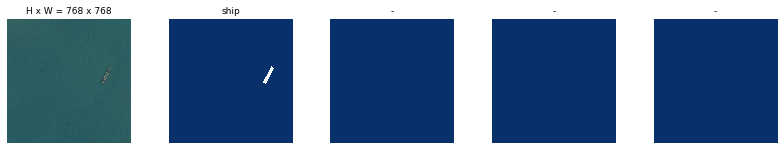

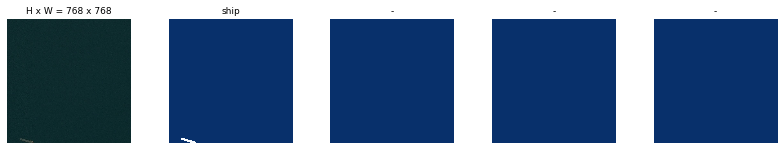

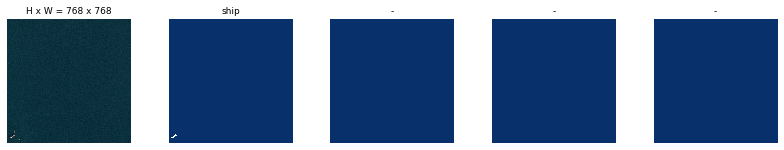

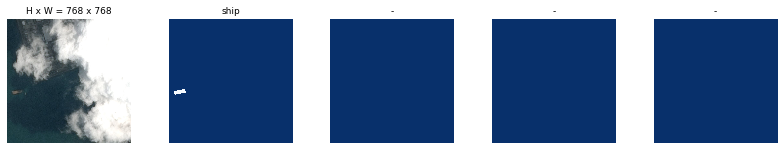

In [26]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  6023 C:\Users\USER\Desktop\kaggle_airbus_ship_detection_challenge\data/train_v2\244936f55.jpg


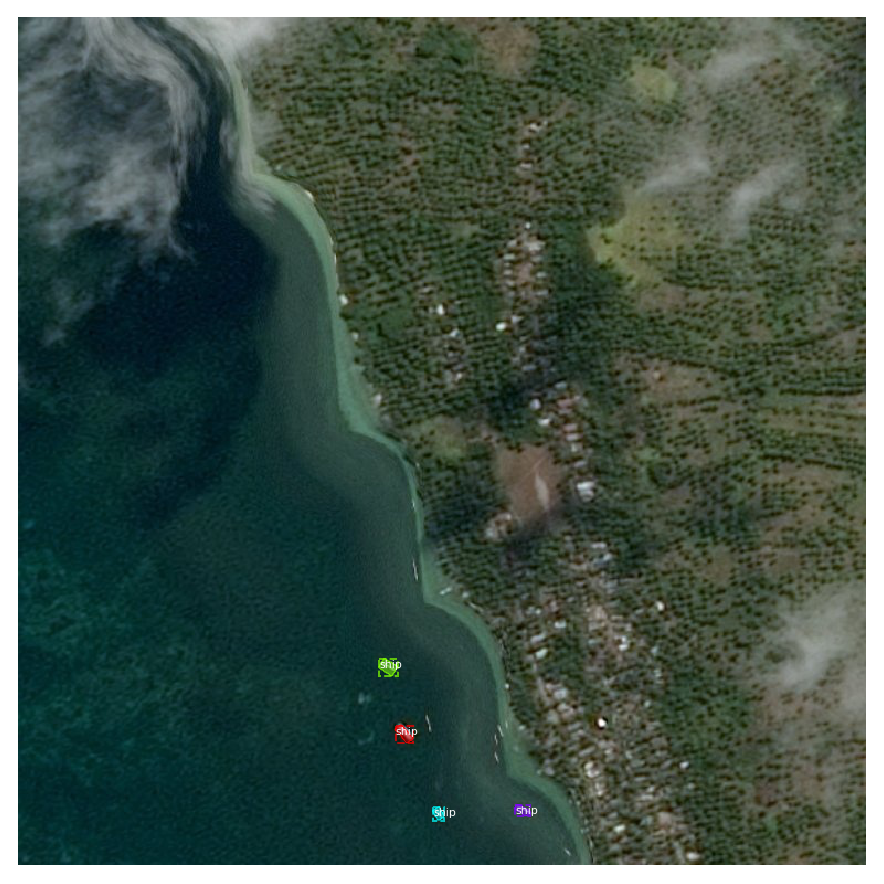

In [27]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Resize Images

800 1024
square
image_id:  30980 C:\Users\USER\Desktop\kaggle_airbus_ship_detection_challenge\data/train_v2\ba84bcac2.jpg
Original shape:  (768, 768, 3)


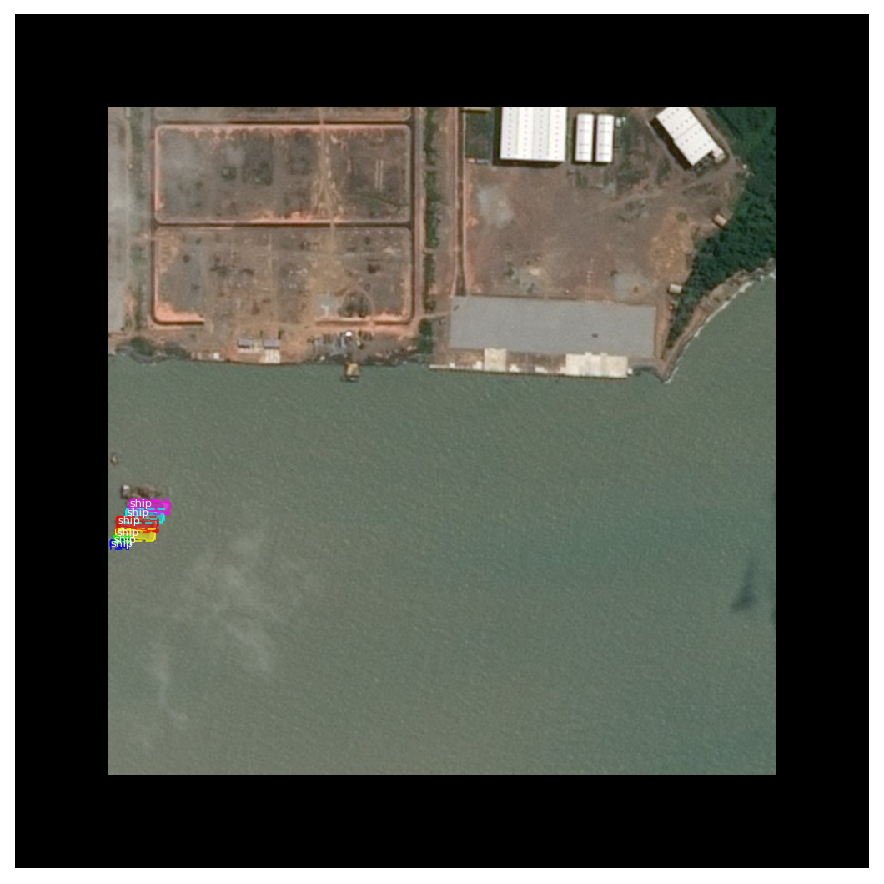

In [28]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape

image, window, scale, padding, _ = utils.resize_image(image,
                                                min_dim=config.IMAGE_MIN_DIM, 
                                                max_dim=config.IMAGE_MAX_DIM,
                                                mode=config.IMAGE_RESIZE_MODE)
print(config.IMAGE_MIN_DIM, config.IMAGE_MAX_DIM)
print(config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

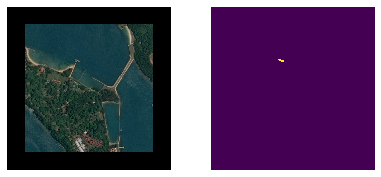

In [29]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

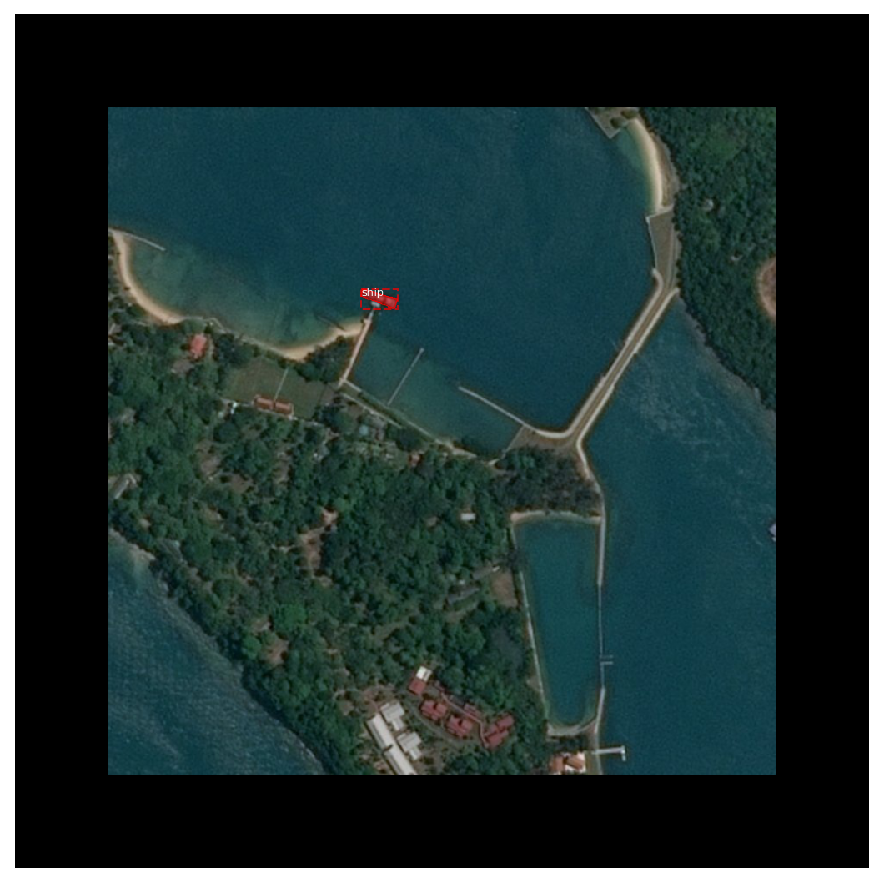

In [30]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

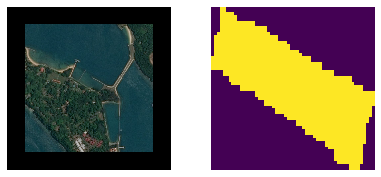

In [31]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

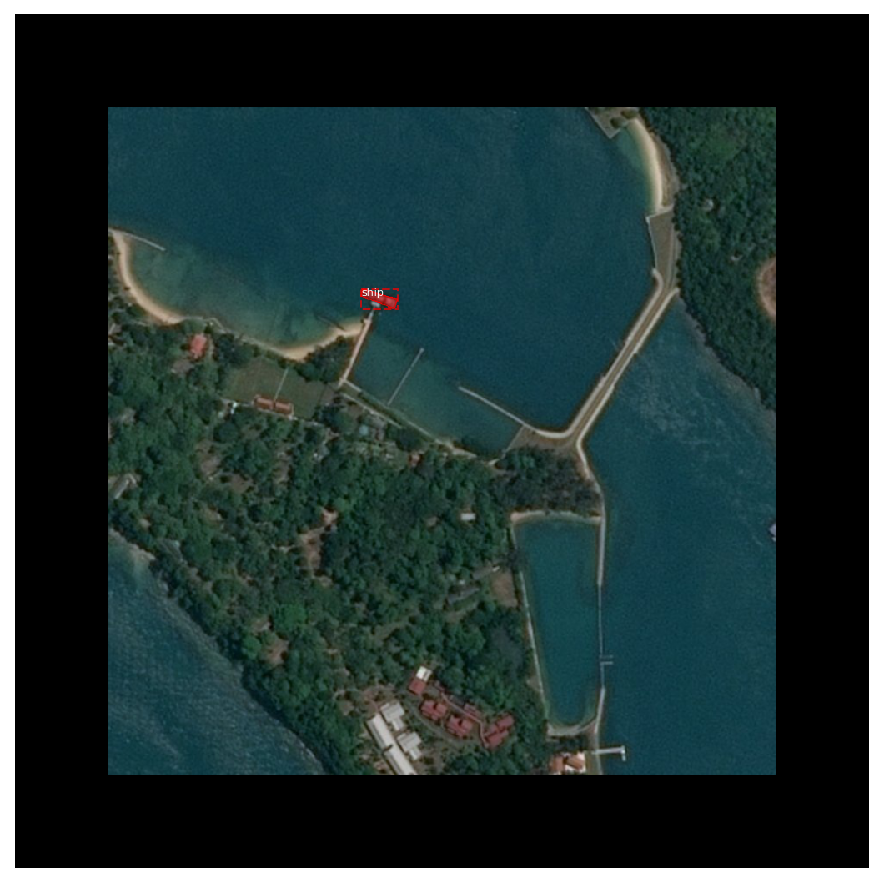

In [36]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Anchors

In [37]:
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                        config.RPN_ANCHOR_RATIOS,
                                        backbone_shapes,
                                        config.BACKBONE_STRIDES, 
                                        config.RPN_ANCHOR_STRIDE)
# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


## Visualize anchors of one cell at the center of the feature map of a specific level

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


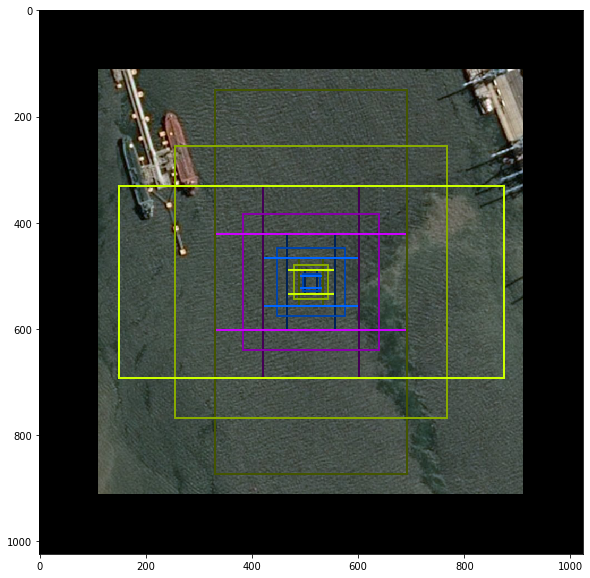

In [38]:
# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                            edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)